In [1]:
'''
Code that uses the MHW definition of Hobday et al. (2016) applied to a OISST time series at a selected location
and outputs summary plots and statistics
'''
import os
import numpy as np
import glob
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 12})
from datetime import date, datetime
# change the dir to where the mhw and mhw_utilities modules are
# otherwise the package won't be available
os.chdir('/a1/julianc/LO_user/extract/stressor/MHW')
# Load required modules for marine heatwaves
import marineHeatWaves as mhw
from mhw_utilities import *


In [2]:
from lo_tools import Lfun
Ldir = Lfun.Lstart()
source = 'OISST'
Ldir['data'] = '/b1'+ '/'+ 'yifan' + '/'+ 'LO_data'
in_dir = Ldir['data'] + '/'+ 'climatology' +'/'+ f'{source}'
# if not os.path.exists(in_dir):
#     os.makedirs(in_dir)
# output location
out_dir = Ldir['LOo'] / 'plots' / 'stressor'/ 'MHW' / 'mhw_stats'
Lfun.make_dir(out_dir, clean=False)

In [3]:
sn_list = {
    #'P04',
      #'P05',
      #'CE042',
      'NH10'}
# --------------------------------------------------------------------------------------
loc = {
    # 'P01': (-125.5000, 48.5750),  # 120 m
    # 'P02': (-126.0000, 48.6000),  # 114 m
    # 'P03': (-126.3333, 48.6250),  # 750 m
    'P04': (-126.6667, 48.6500),  # 1300 m
    'P05': (-127.1667, 48.6917),  # 2100 m
    'P06': (-127.6667, 48.7433),  # 2500 m
    'P07': (-128.1667, 48.7767),  # 2450 m
    'P08': (-128.6667, 48.8167),  # 2440 m
    'P09': (-129.1667, 48.8567),  # 2340 m
    'P10': (-129.6667, 48.8933),  # 2660 m
    'P11': (-130.1667, 48.9333),  # 2700 m
    'P12': (-130.6667, 48.9700),  # 3300 m
    ###
    'CE015': (-124.3481, 47.3568),
    'CE042': (-124.4887, 47.3531),
    'CE065': (-124.5669, 47.3528),
    'NH10': (-124.295, 44.652),  # 81 m
}

## extract selected station from global daily OISST dataset

In [4]:
# Geographic point of intest for time series extraction
# ---
for sn in sn_list:
    lat= loc[sn][1]
    lon= loc[sn][0]

# oisst file details...
# ---
nrows=720
ncols=1440

west_lon=-180
east_lon=+180
north_lat=90
south_lat=-90

# Convert geographic location from lat-lon to row-column
# --------------------------------------------------------------------------------------
icol= int(round((180+lon)*(ncols-1)/(east_lon-west_lon)))
irow= int(round((90-lat)*(nrows-1)/(north_lat-south_lat)))


In [5]:
# Read in daily sst data for a given year from netcdf files and xtract sst value at
# the specified geographic location to build time series day by dday with each time through the loop.
# ---
oisst_series= []
t = []
dates = []
year_list = np.arange(1991,2021)
for year in year_list:
    # print(year)
    folder = f'oisst-{year}' # OISST daily .nc file in year 2014
    fname_list= glob.glob(os.path.expanduser(f'{in_dir}/{folder}/*.nc'))
    fname_list=np.sort(fname_list)  # Note: glob.glob on its own does not retrun a sorted list...
    for fname in fname_list:
        sst_basename=os.path.basename(fname)        
        print('reading sst data from file: ', sst_basename)
        splt_name= sst_basename.split('.')
        date_str = splt_name[1]
        # print(splt_name[1])
        # sst_year= int(splt_name[1][0:4])
        dt = datetime.strptime(date_str, "%Y%m%d").date()
        dates.append(dt)  # Append datetime object
        t.append(dt.toordinal())  # Append ordinal date
        
        year_oisst= read_cdf_prod(fname, 'sst').squeeze()*.01   #0.01 is scale factor give in the file meta data for sst    
        year_oisst=np.flip(year_oisst,axis=0)                   #flip north/south
        year_oisst=np.roll(year_oisst,720, axis=1)              #change lon from (0 to 360) ---> (-180 to +180)    
        oisst_series.append(year_oisst[irow,icol])      
        


reading sst data from file:  oisst-avhrr-v02r01.19910101.nc
reading sst data from file:  oisst-avhrr-v02r01.19910102.nc
reading sst data from file:  oisst-avhrr-v02r01.19910103.nc
reading sst data from file:  oisst-avhrr-v02r01.19910104.nc
reading sst data from file:  oisst-avhrr-v02r01.19910105.nc
reading sst data from file:  oisst-avhrr-v02r01.19910106.nc
reading sst data from file:  oisst-avhrr-v02r01.19910107.nc
reading sst data from file:  oisst-avhrr-v02r01.19910108.nc
reading sst data from file:  oisst-avhrr-v02r01.19910109.nc
reading sst data from file:  oisst-avhrr-v02r01.19910110.nc
reading sst data from file:  oisst-avhrr-v02r01.19910111.nc
reading sst data from file:  oisst-avhrr-v02r01.19910112.nc
reading sst data from file:  oisst-avhrr-v02r01.19910113.nc
reading sst data from file:  oisst-avhrr-v02r01.19910114.nc
reading sst data from file:  oisst-avhrr-v02r01.19910115.nc
reading sst data from file:  oisst-avhrr-v02r01.19910116.nc
reading sst data from file:  oisst-avhrr

In [6]:
# replace sst using real data from OISST
sst = np.array(oisst_series)
t = np.array(t)
dates = np.array(dates)
# --------------------------------------------------------------------------------------
# Some basic parameters
coldSpells = False # If true detect coldspells instead of heatwaves
col_clim = '0.25'
col_thresh = 'g-'
if coldSpells:
    mhwname = 'MCS'
    mhwfullname = 'coldspell'
    col_evMax = (0, 102./255, 204./255)
    col_ev = (153./255, 204./255, 1)
    col_bar = (0.5, 0.5, 1)
else:
    mhwname = 'MHW'
    mhwfullname = 'heatwave'
    col_evMax = 'r'
    col_ev = (1, 0.6, 0.5)
    col_bar = (1, 0.5, 0.5)


In [7]:
# Apply Marine Heat Wave definition
n = 0
mhws, clim = mhw.detect(t, sst, coldSpells=coldSpells)
mhwBlock = mhw.blockAverage(t, mhws, temp=sst)
mean, trend, dtrend = mhw.meanTrend(mhwBlock)

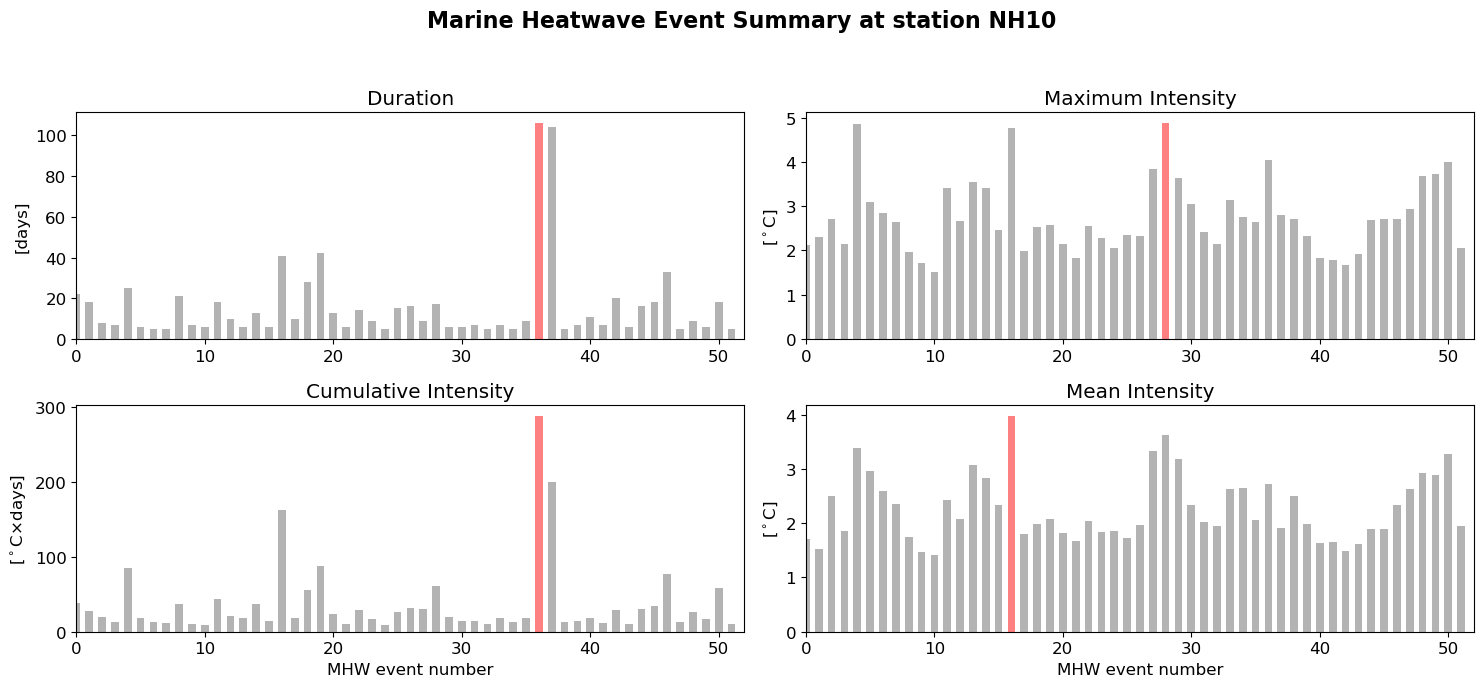

In [8]:
# Plot various summary things
plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(range(mhws['n_events']), mhws['duration'], width=0.6, color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['duration'][evMax], width=0.6, color=col_bar)
plt.xlim(0, mhws['n_events'])
plt.ylabel('[days]')
plt.title('Duration')
plt.subplot(2,2,2)
evMax = np.argmax(np.abs(mhws['intensity_max']))
plt.bar(range(mhws['n_events']), mhws['intensity_max'], width=0.6, color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_max'][evMax], width=0.6, color=col_bar)
plt.xlim(0, mhws['n_events'])
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
plt.subplot(2,2,4)
evMax = np.argmax(np.abs(mhws['intensity_mean']))
plt.bar(range(mhws['n_events']), mhws['intensity_mean'], width=0.6, color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_mean'][evMax], width=0.6, color=col_bar)
plt.xlim(0, mhws['n_events'])
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.xlabel(mhwname + ' event number')
plt.subplot(2,2,3)
evMax = np.argmax(np.abs(mhws['intensity_cumulative']))
plt.bar(range(mhws['n_events']), mhws['intensity_cumulative'], width=0.6, color=(0.7,0.7,0.7))
plt.bar(evMax, mhws['intensity_cumulative'][evMax], width=0.6, color=col_bar)
plt.xlim(0, mhws['n_events'])
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.xlabel(mhwname + ' event number')
# Add a figure-level title
plt.suptitle(f'Marine Heatwave Event Summary at station {sn}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle
plt.savefig(f'{out_dir}'+ '/' + mhwname + f'_from_{source}'+ f'_list_byNumber_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)
plt.show()

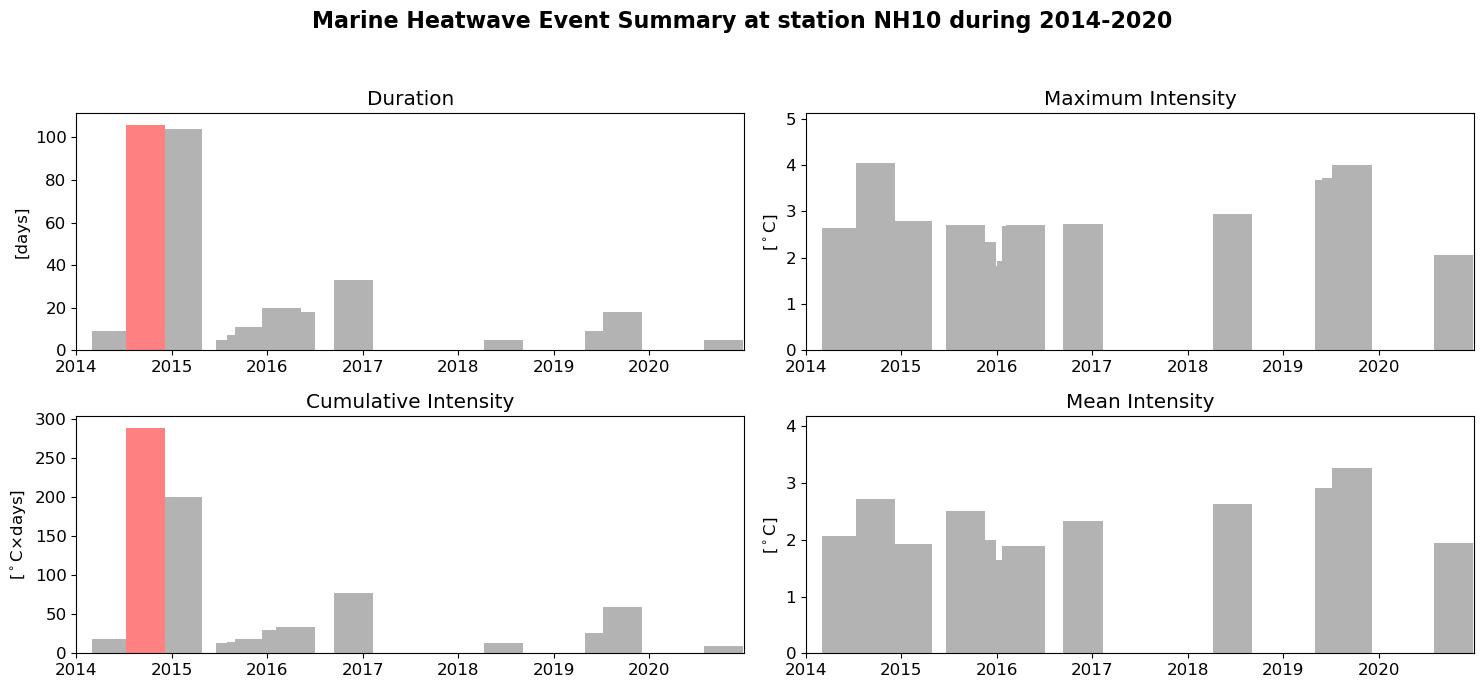

In [9]:
yr1 = 2014
yr2 = 2020
ts = date(yr1,1,1).toordinal()
te = date(yr2,12,31).toordinal()

plt.figure(figsize=(15,7))
plt.subplot(2,2,1)
evMax = np.argmax(mhws['duration'])
plt.bar(mhws['date_peak'], mhws['duration'], width=150, color=(0.7,0.7,0.7))
plt.bar(mhws['date_peak'][evMax], mhws['duration'][evMax], width=150, color=col_bar)
plt.xlim(date.fromordinal(ts), date.fromordinal(te))

plt.ylabel('[days]')
plt.title('Duration')
plt.subplot(2,2,2)
evMax = np.argmax(np.abs(mhws['intensity_max']))
plt.bar(mhws['date_peak'], mhws['intensity_max'], width=150, color=(0.7,0.7,0.7))
plt.bar(mhws['date_peak'][evMax], mhws['intensity_max'][evMax], width=150, color=col_bar)
plt.xlim(date.fromordinal(ts), date.fromordinal(te))
plt.ylabel(r'[$^\circ$C]')
plt.title('Maximum Intensity')
plt.subplot(2,2,4)
evMax = np.argmax(np.abs(mhws['intensity_mean']))
plt.bar(mhws['date_peak'], mhws['intensity_mean'], width=150, color=(0.7,0.7,0.7))
plt.bar(mhws['date_peak'][evMax], mhws['intensity_mean'][evMax], width=150, color=col_bar)
plt.xlim(date.fromordinal(ts), date.fromordinal(te))
plt.title('Mean Intensity')
plt.ylabel(r'[$^\circ$C]')
plt.subplot(2,2,3)
evMax = np.argmax(np.abs(mhws['intensity_cumulative']))
plt.bar(mhws['date_peak'], mhws['intensity_cumulative'], width=150, color=(0.7,0.7,0.7))
plt.bar(mhws['date_peak'][evMax], mhws['intensity_cumulative'][evMax], width=150, color=col_bar)
plt.xlim(date.fromordinal(ts), date.fromordinal(te))
plt.title(r'Cumulative Intensity')
plt.ylabel(r'[$^\circ$C$\times$days]')

# Add a figure-level title
plt.suptitle(f'Marine Heatwave Event Summary at station {sn} during {yr1}-{yr2}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle
plt.savefig(f'{out_dir}'+ '/'+ mhwname +  f'_from_{source}'+ f'_list_byDate_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)
plt.show()


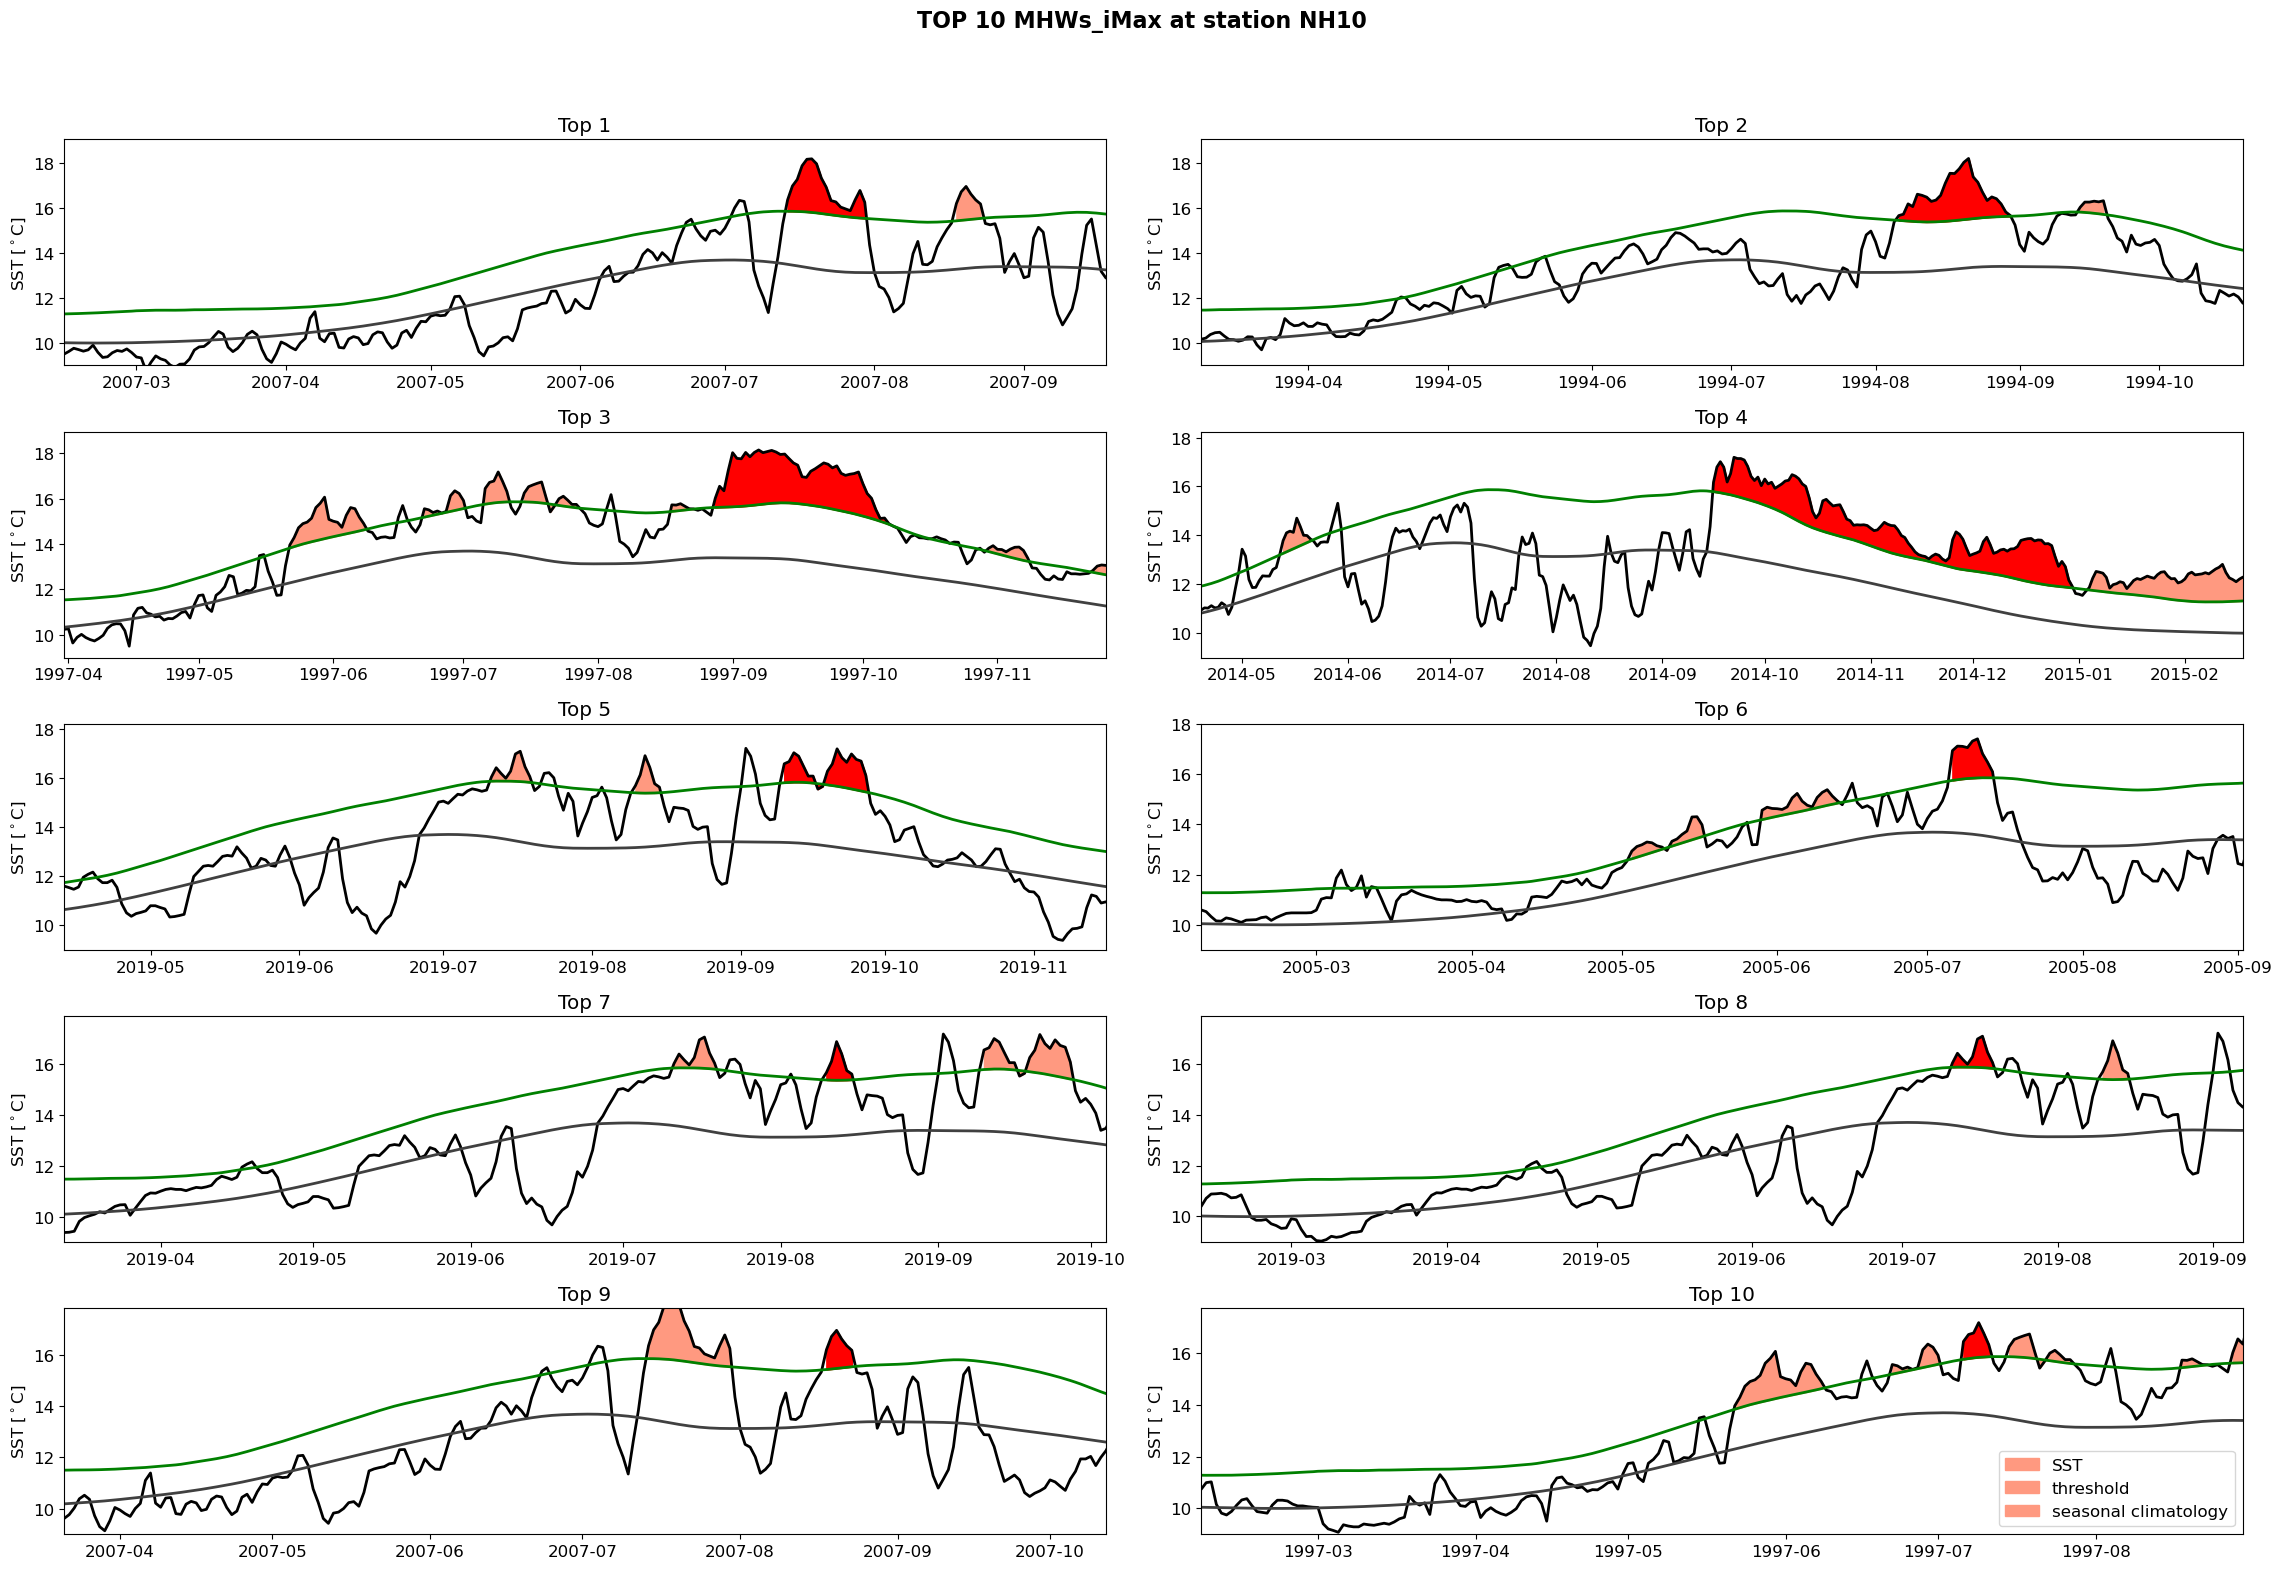

In [10]:
# Plot top 10 events
# Maximum intensity
outfile = open(f'{out_dir}'+ '/' + mhwname + '_topTen_iMax.txt', 'w')
evs = np.argsort(np.abs(mhws['intensity_max']))[-10:]
plt.figure(figsize=(23,16))
for i in range(10):
    ev = evs[-(i+1)]
    plt.subplot(5,2,i+1)
    # Find indices for all ten MHWs before and after event of interest and shade accordingly
    for ev0 in np.arange(max(ev-10,0), min(ev+11,mhws['n_events']-1), 1):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_ev)
    # Find indices for MHW of interest (2011 WA event) and shade accordingly
    t1 = np.where(t==mhws['time_start'][ev])[0][0]
    t2 = np.where(t==mhws['time_end'][ev])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_evMax)
    # Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, sst, 'k-', linewidth=2)
    plt.plot(dates, clim['thresh'], col_thresh, linewidth=2)
    plt.plot(dates, clim['seas'], col_clim, linewidth=2)
    plt.title('Top ' + str(i+1))
    plt.xlim(date.fromordinal(mhws['time_start'][ev]-150), date.fromordinal(mhws['time_end'][ev]+50))
    if coldSpells:
        plt.ylim(clim['seas'].min() + mhws['intensity_max'][ev] - 0.5, clim['seas'].max() + 1)
    else:
        plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
    plt.ylabel(r'SST [$^\circ$C]')
    # Save stats
    outfile.write('Number ' + str(i+1) + '\n')
    outfile.write('Maximum intensity: ' + str(mhws['intensity_max'][ev]) + ' deg. C\n')
    outfile.write('Average intensity: '+ str( mhws['intensity_mean'][ev]) + ' deg. C\n')
    outfile.write('Cumulative intensity: ' + str(mhws['intensity_cumulative'][ev]) + ' deg. C-days\n')
    outfile.write('Duration: ' + str(mhws['duration'][ev]) + ' days\n')
    outfile.write('Start date: ' + str(mhws['date_start'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('End date: ' + str(mhws['date_end'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('\n')

plt.legend(['SST', 'threshold', 'seasonal climatology'], loc=4)
outfile.close()
# Add a figure-level title
plt.suptitle(f'TOP 10 MHWs_iMax at station {sn}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle
plt.savefig(f'{out_dir}'+ '/' + mhwname +  f'_from_{source}'+ f'_topTen_iMax_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)


<Figure size 640x480 with 0 Axes>

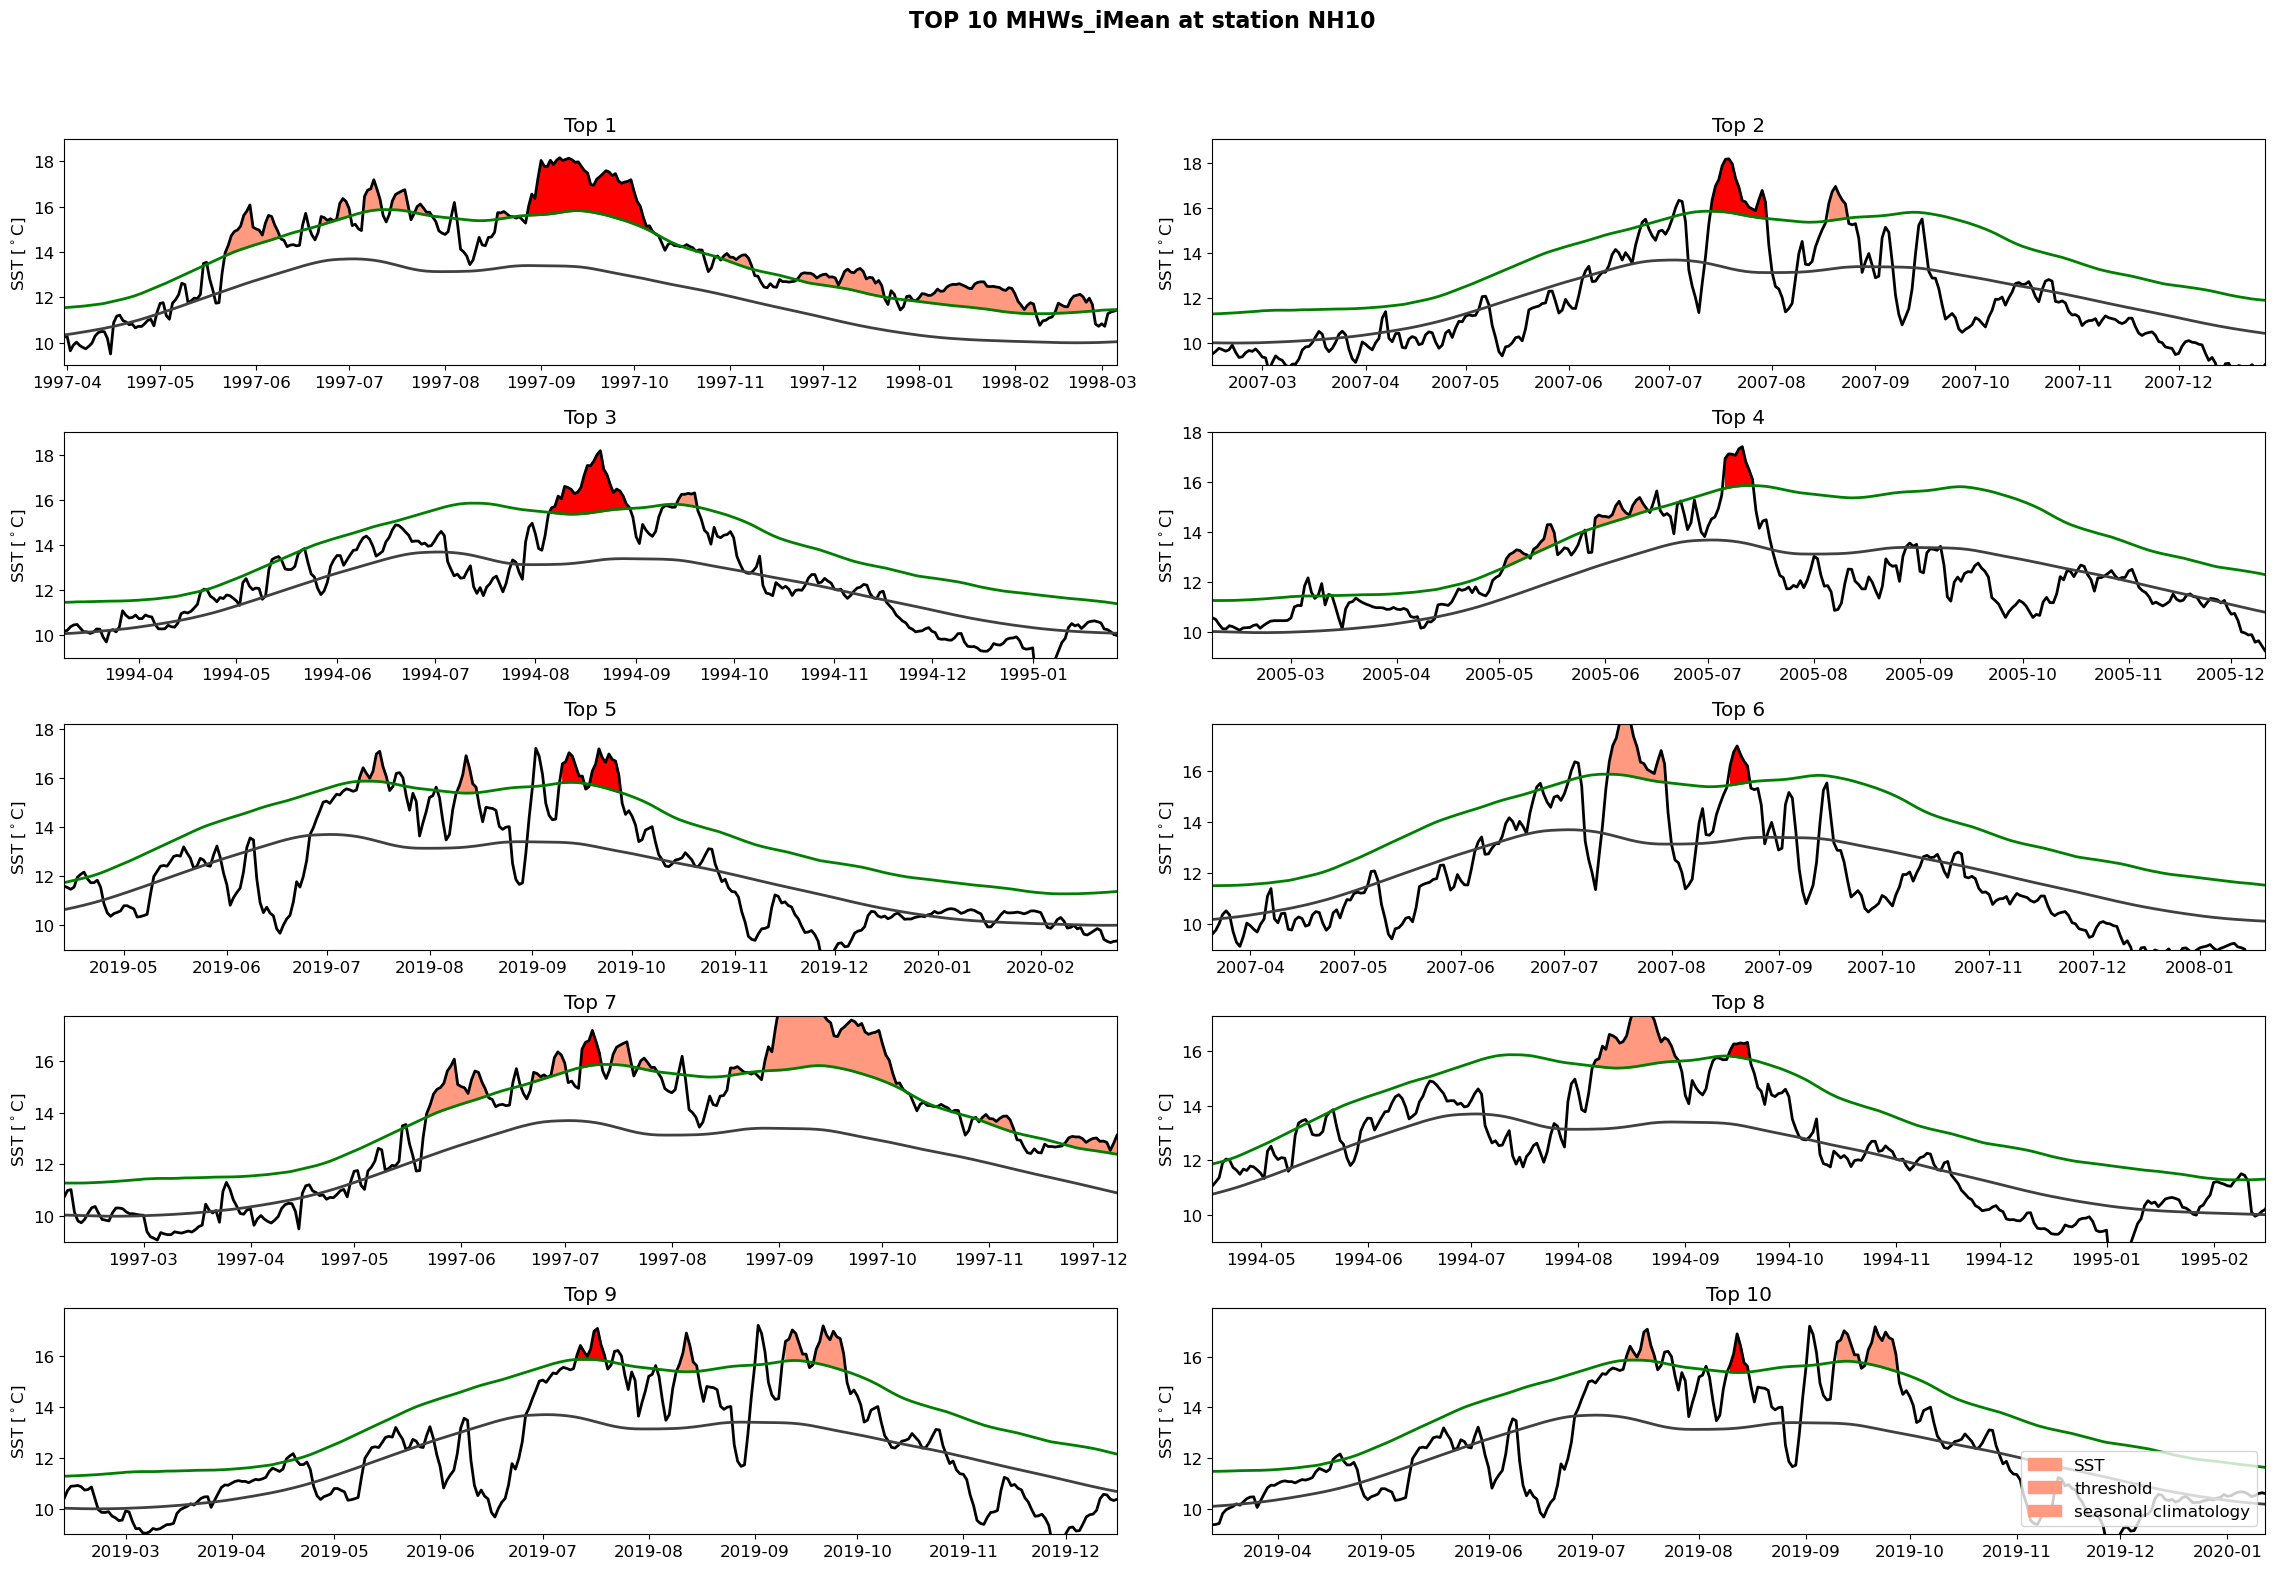

In [11]:
# Mean intensity
outfile = open(f'{out_dir}'+ '/' + mhwname + '_topTen_iMean.txt', 'w')
evs = np.argsort(np.abs(mhws['intensity_mean']))[-10:]
plt.clf()
plt.figure(figsize=(23,16))
for i in range(10):
    ev = evs[-(i+1)]
    plt.subplot(5,2,i+1)
    # Find indices for all ten MHWs before and after event of interest and shade accordingly
    for ev0 in np.arange(max(ev-10,0), min(ev+11,mhws['n_events']-1), 1):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_ev)
    # Find indices for MHW of interest (2011 WA event) and shade accordingly
    t1 = np.where(t==mhws['time_start'][ev])[0][0]
    t2 = np.where(t==mhws['time_end'][ev])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_evMax)
    # Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, sst, 'k-', linewidth=2)
    plt.plot(dates, clim['thresh'], col_thresh, linewidth=2)
    plt.plot(dates, clim['seas'], col_clim, linewidth=2)
    plt.title('Top ' + str(i+1))
    plt.xlim(date.fromordinal(mhws['time_start'][ev]-150), date.fromordinal(mhws['time_end'][ev]+150))
    if coldSpells:
        plt.ylim(clim['seas'].min() + mhws['intensity_max'][ev] - 0.5, clim['seas'].max() + 1)
    else:
        plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
    plt.ylabel(r'SST [$^\circ$C]')
    # Save stats
    outfile.write('Number ' + str(i+1) + '\n')
    outfile.write('Maximum intensity: ' + str(mhws['intensity_max'][ev]) + ' deg. C\n')
    outfile.write('Average intensity: '+ str( mhws['intensity_mean'][ev]) + ' deg. C\n')
    outfile.write('Cumulative intensity: ' + str(mhws['intensity_cumulative'][ev]) + ' deg. C-days\n')
    outfile.write('Duration: ' + str(mhws['duration'][ev]) + ' days\n')
    outfile.write('Start date: ' + str(mhws['date_start'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('End date: ' + str(mhws['date_end'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('\n')
plt.legend(['SST', 'threshold', 'seasonal climatology'], loc=4)
outfile.close()
plt.suptitle(f'TOP 10 MHWs_iMean at station {sn}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle

plt.savefig(f'{out_dir}'+ '/' + mhwname +  f'_from_{source}'+ f'_topTen_iMean_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)

<Figure size 640x480 with 0 Axes>

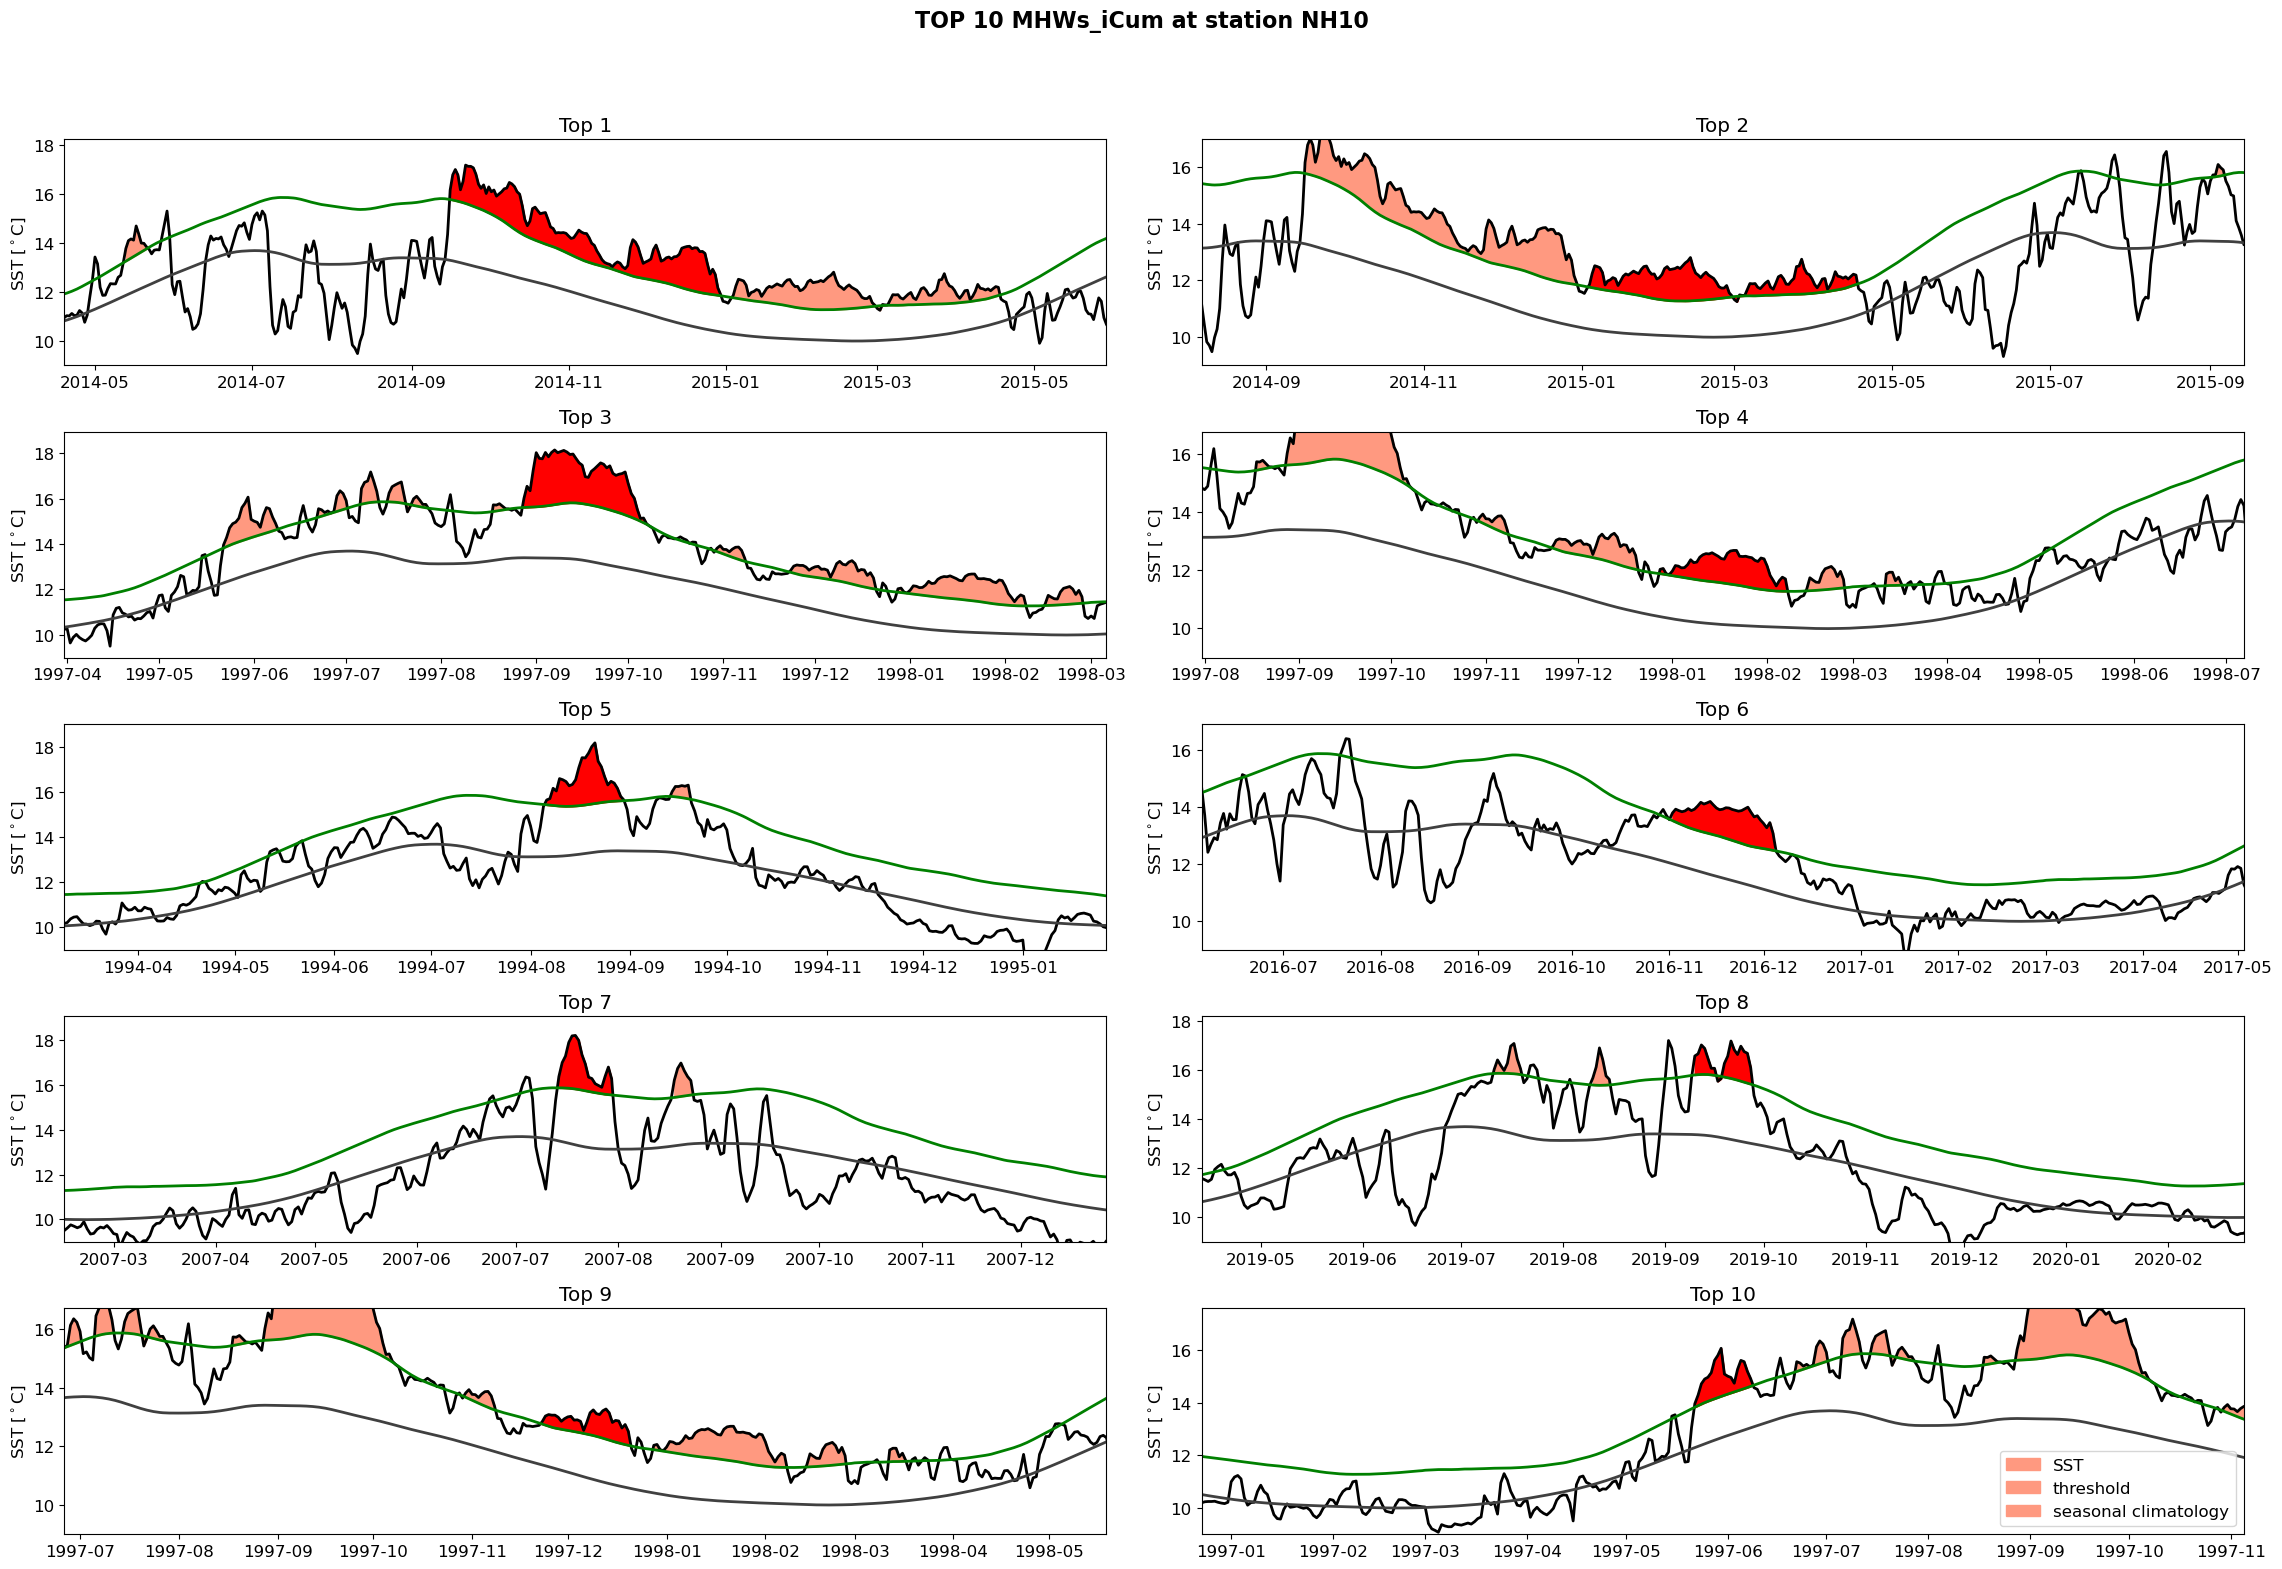

In [12]:
# Cumulative intensity
outfile = open(f'{out_dir}'+ '/'+  mhwname + '_topTen_iCum.txt', 'w')
evs = np.argsort(np.abs(mhws['intensity_cumulative']))[-10:]
plt.clf()
plt.figure(figsize=(23,16))
for i in range(10):
    ev = evs[-(i+1)]
    plt.subplot(5,2,i+1)
    # Find indices for all ten MHWs before and after event of interest and shade accordingly
    for ev0 in np.arange(max(ev-10,0), min(ev+11,mhws['n_events']-1), 1):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_ev)
    # Find indices for MHW of interest (2011 WA event) and shade accordingly
    t1 = np.where(t==mhws['time_start'][ev])[0][0]
    t2 = np.where(t==mhws['time_end'][ev])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_evMax)
    # Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, sst, 'k-', linewidth=2)
    plt.plot(dates, clim['thresh'], col_thresh, linewidth=2)
    plt.plot(dates, clim['seas'], col_clim, linewidth=2)
    plt.title('Top ' + str(i+1))
    plt.xlim(date.fromordinal(mhws['time_start'][ev]-150), date.fromordinal(mhws['time_end'][ev]+150))
    if coldSpells:
        plt.ylim(clim['seas'].min() + mhws['intensity_max'][ev] - 0.5, clim['seas'].max() + 1)
    else:
        plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
    plt.ylabel(r'SST [$^\circ$C]')
    # Save stats
    outfile.write('Number ' + str(i+1) + '\n')
    outfile.write('Maximum intensity: ' + str(mhws['intensity_max'][ev]) + ' deg. C\n')
    outfile.write('Average intensity: '+ str( mhws['intensity_mean'][ev]) + ' deg. C\n')
    outfile.write('Cumulative intensity: ' + str(mhws['intensity_cumulative'][ev]) + ' deg. C-days\n')
    outfile.write('Duration: ' + str(mhws['duration'][ev]) + ' days\n')
    outfile.write('Start date: ' + str(mhws['date_start'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('End date: ' + str(mhws['date_end'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('\n')

plt.legend(['SST', 'threshold', 'seasonal climatology'], loc=4)
outfile.close()

plt.suptitle(f'TOP 10 MHWs_iCum at station {sn}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle

plt.savefig(f'{out_dir}'+ '/' + mhwname +  f'_from_{source}'+ f'_topTen_iCum_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)

<Figure size 640x480 with 0 Axes>

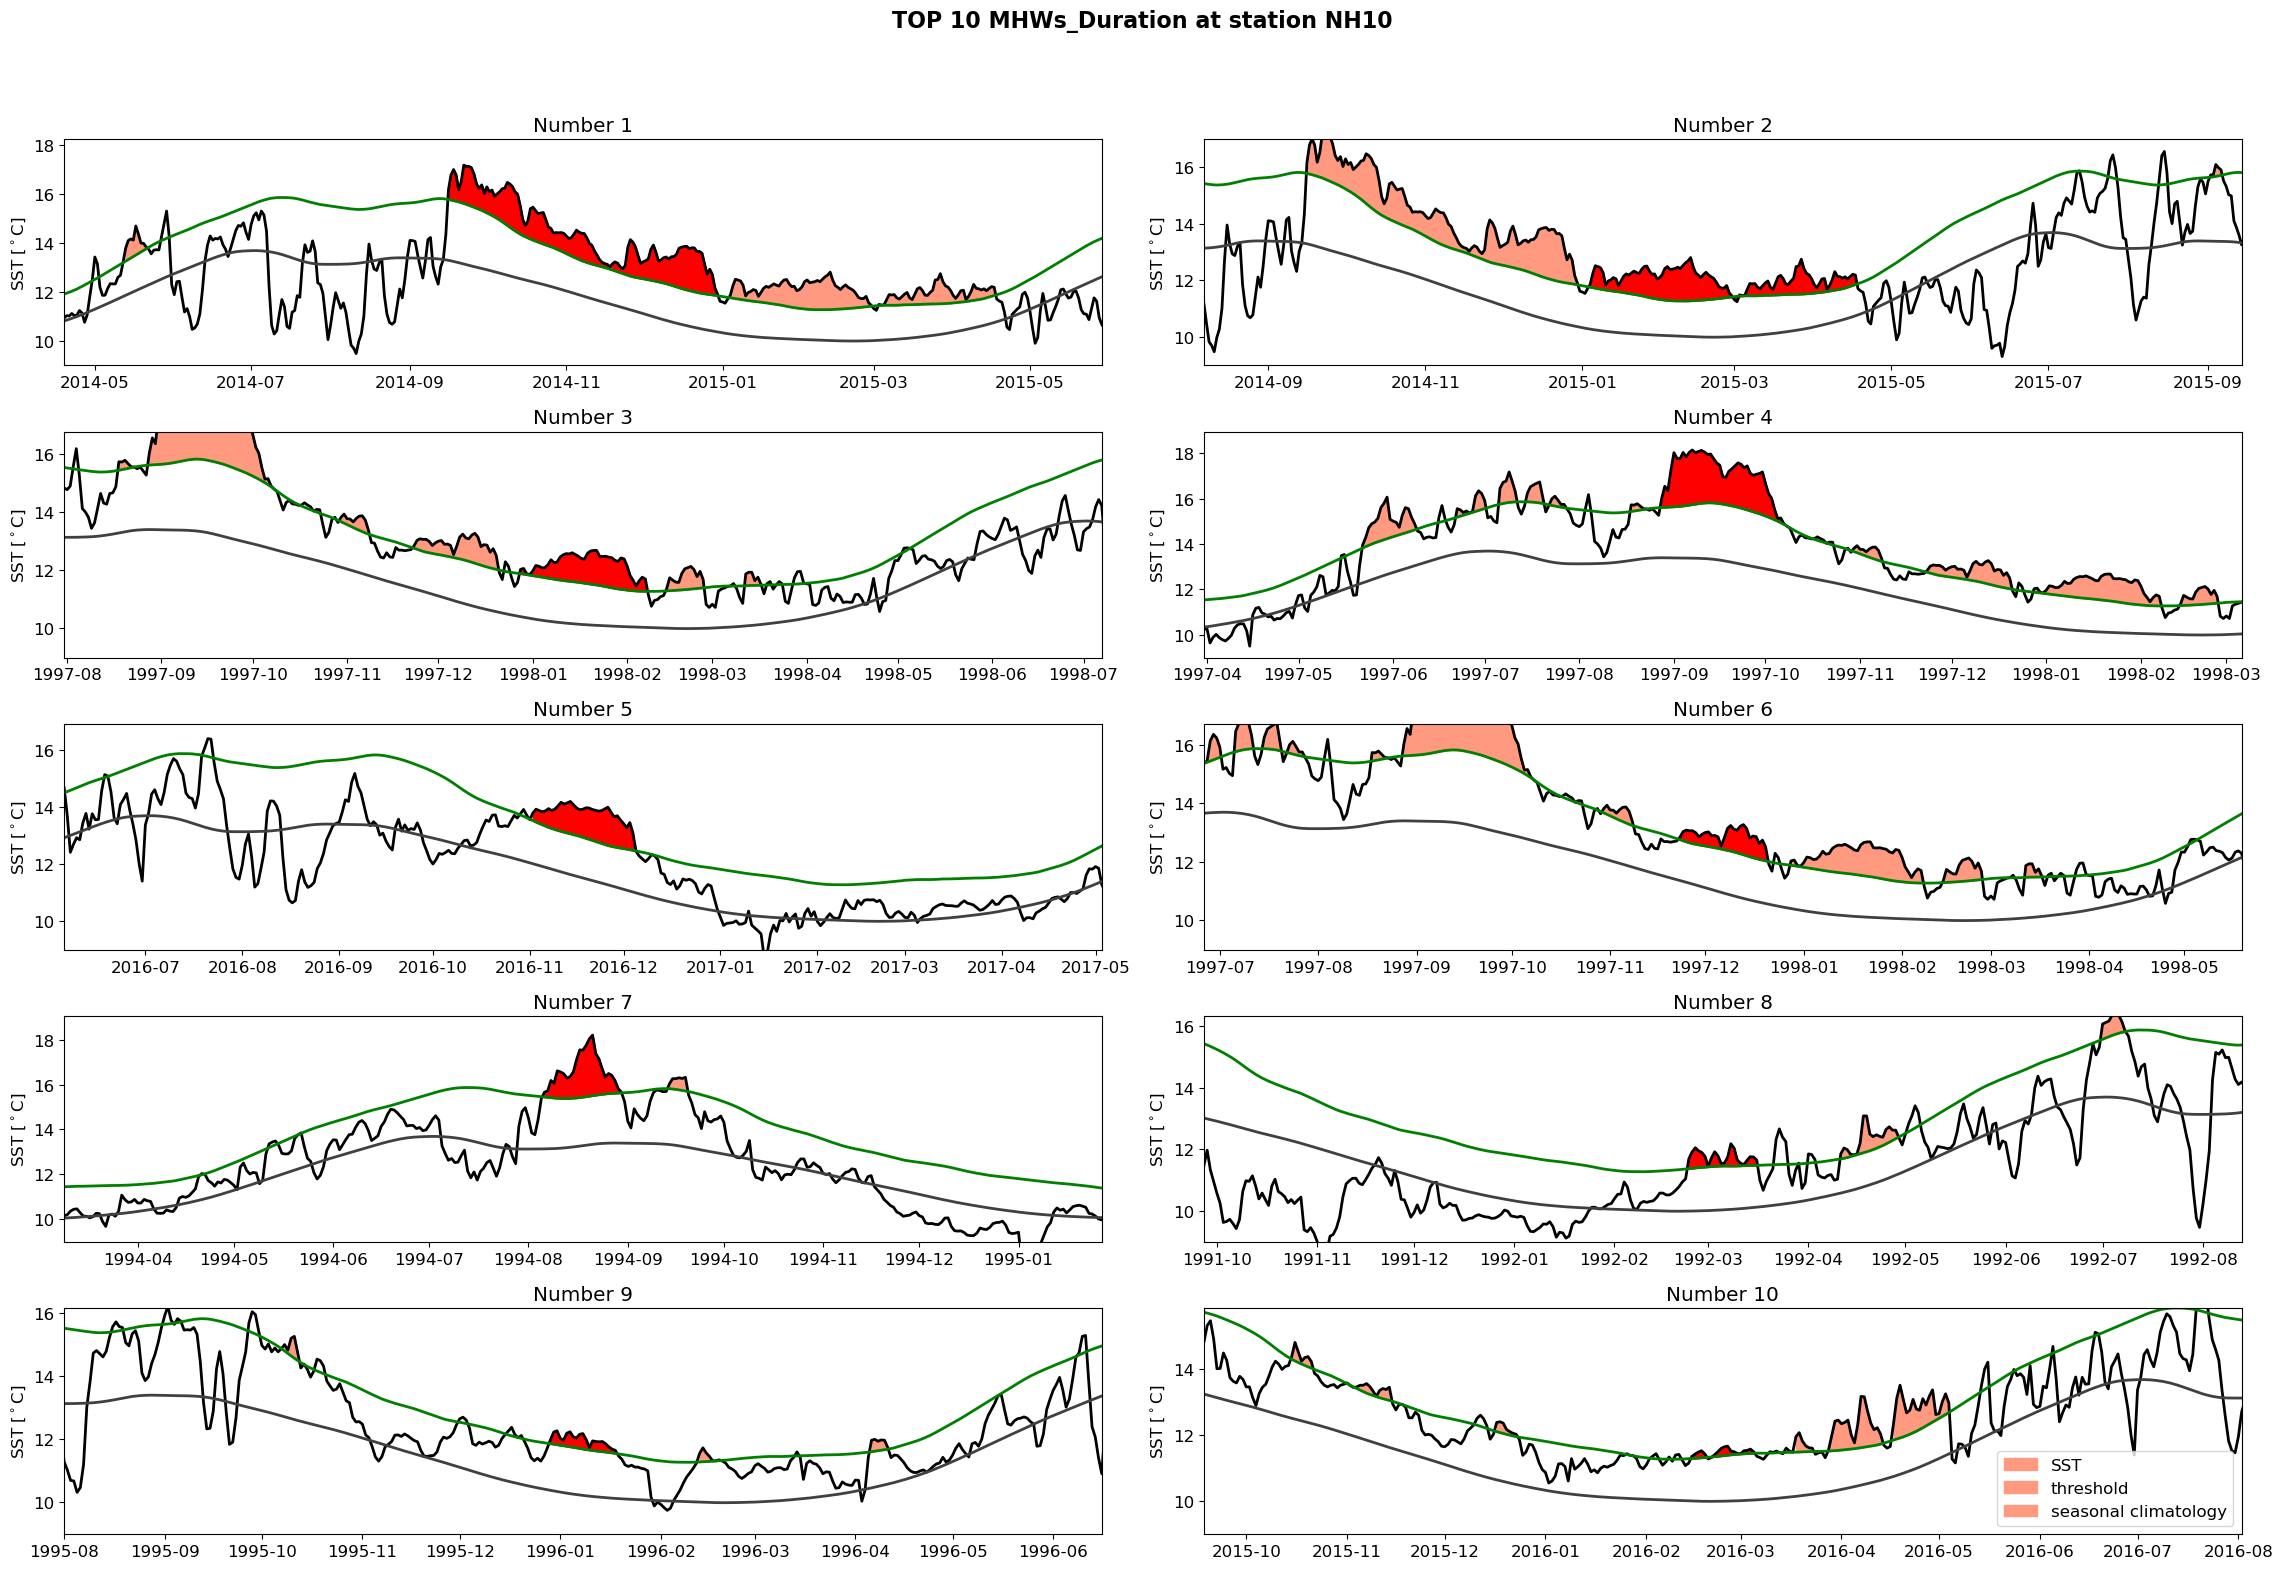

In [13]:
# Duration
outfile = open(f'{out_dir}'+ '/'+  mhwname + '_topTen_Dur.txt', 'w')
evs = np.argsort(mhws['duration'])[-10:]
plt.clf()
plt.figure(figsize=(23,16))
for i in range(10):
    ev = evs[-(i+1)]
    plt.subplot(5,2,i+1)
    # Find indices for all ten MHWs before and after event of interest and shade accordingly
    for ev0 in np.arange(max(ev-10,0), min(ev+11,mhws['n_events']-1), 1):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_ev)
    # Find indices for MHW of interest (2011 WA event) and shade accordingly
    t1 = np.where(t==mhws['time_start'][ev])[0][0]
    t2 = np.where(t==mhws['time_end'][ev])[0][0]
    plt.fill_between(dates[t1:t2+1], sst[t1:t2+1], clim['thresh'][t1:t2+1], color=col_evMax)
    # Plot SST, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, sst, 'k-', linewidth=2)
    plt.plot(dates, clim['thresh'], col_thresh, linewidth=2)
    plt.plot(dates, clim['seas'], col_clim, linewidth=2)
    plt.title('Number ' + str(i+1))
    plt.xlim(date.fromordinal(mhws['time_start'][ev]-150), date.fromordinal(mhws['time_end'][ev]+150))
    if coldSpells:
        plt.ylim(clim['seas'].min() + mhws['intensity_max'][ev] - 0.5, clim['seas'].max() + 1)
    else:
        plt.ylim(clim['seas'].min() - 1, clim['seas'].max() + mhws['intensity_max'][ev] + 0.5)
    plt.ylabel(r'SST [$^\circ$C]')
    # Save stats
    outfile.write('Number ' + str(i+1) + '\n')
    outfile.write('Maximum intensity: ' + str(mhws['intensity_max'][ev]) + ' deg. C\n')
    outfile.write('Average intensity: '+ str( mhws['intensity_mean'][ev]) + ' deg. C\n')
    outfile.write('Cumulative intensity: ' + str(mhws['intensity_cumulative'][ev]) + ' deg. C-days\n')
    outfile.write('Duration: ' + str(mhws['duration'][ev]) + ' days\n')
    outfile.write('Start date: ' + str(mhws['date_start'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('End date: ' + str(mhws['date_end'][ev].strftime("%d %B %Y")) + '\n')
    outfile.write('\n')

plt.legend(['SST', 'threshold', 'seasonal climatology'], loc=4)
outfile.close()

plt.suptitle(f'TOP 10 MHWs_Duration at station {sn}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle

plt.savefig(f'{out_dir}'+ '/' + mhwname +  f'_from_{source}'+ f'_topTen_Duration_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)

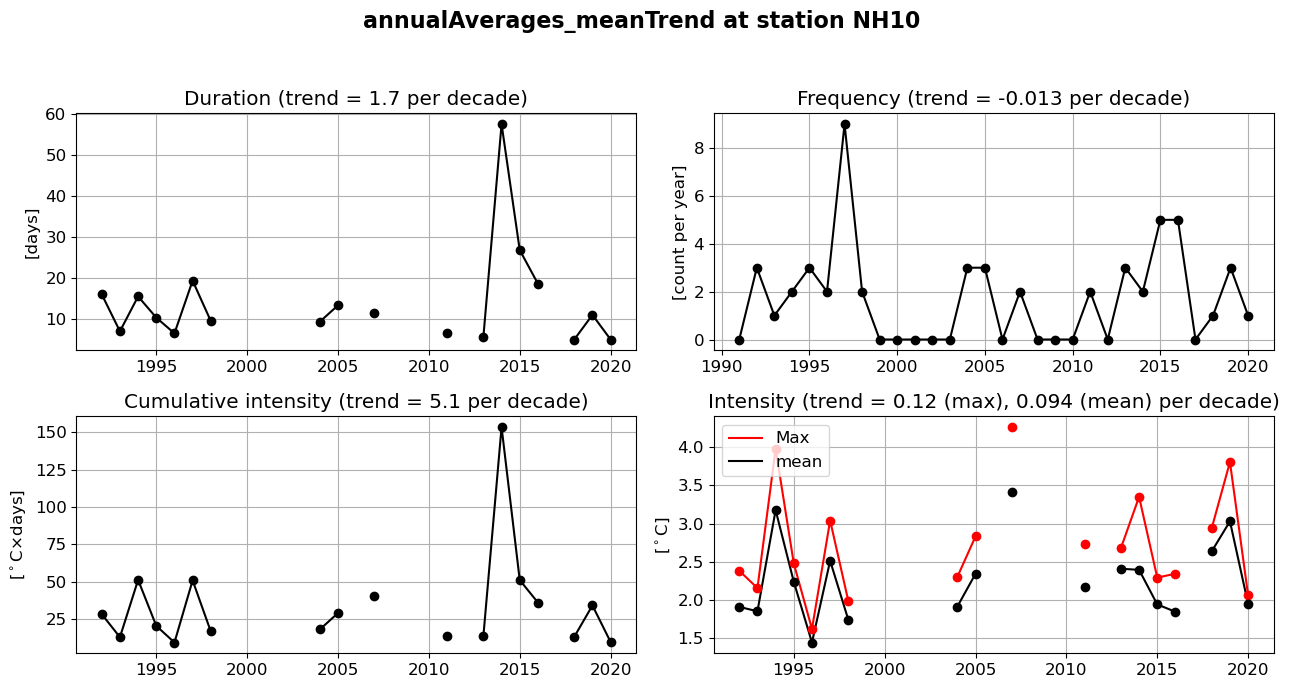

In [14]:
# Annual averages
years = mhwBlock['years_centre']
plt.figure(figsize=(13,7))
plt.subplot(2,2,2)
plt.plot(years, mhwBlock['count'], 'k-')
plt.plot(years, mhwBlock['count'], 'ko')
if np.abs(trend['count']) - dtrend['count'] > 0:
     plt.title('Frequency (trend = ' + '{:.2}'.format(10*trend['count']) + '* per decade)')
else:
     plt.title('Frequency (trend = ' + '{:.2}'.format(10*trend['count']) + ' per decade)')
plt.ylabel('[count per year]')
plt.grid()
plt.subplot(2,2,1)
plt.plot(years, mhwBlock['duration'], 'k-')
plt.plot(years, mhwBlock['duration'], 'ko')
if np.abs(trend['duration']) - dtrend['duration'] > 0:
    plt.title('Duration (trend = ' + '{:.2}'.format(10*trend['duration']) + '* per decade)')
else:
    plt.title('Duration (trend = ' + '{:.2}'.format(10*trend['duration']) + ' per decade)')
plt.ylabel('[days]')
plt.grid()
plt.subplot(2,2,4)
plt.plot(years, mhwBlock['intensity_max'], '-', color=col_evMax)
plt.plot(years, mhwBlock['intensity_mean'], 'k-')
plt.plot(years, mhwBlock['intensity_max'], 'o', color=col_evMax)
plt.plot(years, mhwBlock['intensity_mean'], 'ko')
plt.legend(['Max', 'mean'], loc=2)
if (np.abs(trend['intensity_max']) - dtrend['intensity_max'] > 0) * (np.abs(trend['intensity_mean']) - dtrend['intensity_mean'] > 0):
    plt.title('Intensity (trend = ' + '{:.2}'.format(10*trend['intensity_max']) + '* (max), ' + '{:.2}'.format(10*trend['intensity_mean'])  + '* (mean) per decade)')
elif (np.abs(trend['intensity_max']) - dtrend['intensity_max'] > 0):
    plt.title('Intensity (trend = ' + '{:.2}'.format(10*trend['intensity_max']) + '* (max), ' + '{:.2}'.format(10*trend['intensity_mean'])  + ' (mean) per decade)')
elif (np.abs(trend['intensity_mean']) - dtrend['intensity_mean'] > 0):
    plt.title('Intensity (trend = ' + '{:.2}'.format(10*trend['intensity_max']) + ' (max), ' + '{:.2}'.format(10*trend['intensity_mean'])  + '* (mean) per decade)')
else:
    plt.title('Intensity (trend = ' + '{:.2}'.format(10*trend['intensity_max']) + ' (max), ' + '{:.2}'.format(10*trend['intensity_mean'])  + ' (mean) per decade)')
plt.ylabel(r'[$^\circ$C]')
plt.grid()
plt.subplot(2,2,3)
plt.plot(years, mhwBlock['intensity_cumulative'], 'k-')
plt.plot(years, mhwBlock['intensity_cumulative'], 'ko')
if np.abs(trend['intensity_cumulative']) - dtrend['intensity_cumulative'] > 0:
    plt.title('Cumulative intensity (trend = ' + '{:.2}'.format(10*trend['intensity_cumulative']) + '* per decade)')
else:
    plt.title('Cumulative intensity (trend = ' + '{:.2}'.format(10*trend['intensity_cumulative']) + ' per decade)')
plt.ylabel(r'[$^\circ$C$\times$days]')
plt.grid()

plt.suptitle(f'annualAverages_meanTrend at station {sn}', fontsize=16, fontweight='bold')
# Show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle

plt.savefig(f'{out_dir}'+ '/' + mhwname +  f'_from_{source}'+ f'_annualAverages_meanTrend_at_{sn}.png', bbox_inches='tight', pad_inches=0.5, dpi=150)

In [15]:
# Save results as text data
outfile = f'{out_dir}'+ '/'+  mhwname + '_data'
# Event data
csvfile = open(outfile +'.events.csv', 'w')
#csvfile.write('# Marine heatwave statistics for individual detected events at [' + str(lon[i]) + ' E ' + str(lat[j]) + ' N] from NOAA OI AVHRR V2 SST data (1982-2014)\n')
csvfile.write('# Marine ' + mhwfullname + ' statistics for individual detected events at ' + sn + ' from NOAA OI AVHRR V2 SST data (1991-2020)\n')
csvfile.write('Event number, Start year, Start month, Start day, Peak year, Peak month, Peak day, End year, End month, End day, Duration [days], Maximum intensity [deg C], Mean intensity [deg C], Cumulative intensity [deg C x days], Intensity variability [deg C], Rate of onset [deg C / days], Rate of decline [deg C / days], Maximum intensity (rel. thresh.) [deg C], Mean intensity (rel. thresh.) [deg C], Cumulative intensity (rel. thresh.) [deg C x days], Intensity variability (rel. thresh.) [deg C], Maximum intensity (absolute) [deg C], Mean intensity (absolute) [deg C], Cumulative intensity (absolute) [deg C x days], Intensity variability (absolute) [deg C], Maximum intensity (normalized) [unitless], Mean intensity (normalized) [unitless]\n')
for ev in range(mhws['n_events']):
    csvfile.write(str(ev+1) + ', ' + str(mhws['date_start'][ev].year) + ', ' + str(mhws['date_start'][ev].month) + ', ' + str(mhws['date_start'][ev].day) + ', ' + str(mhws['date_peak'][ev].year) + ', ' + str(mhws['date_peak'][ev].month) + ', ' + str(mhws['date_peak'][ev].day) + ', ' + str(mhws['date_end'][ev].year) + ', ' + str(mhws['date_end'][ev].month) + ', ' + str(mhws['date_end'][ev].day) + ', ' + str(mhws['duration'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_max'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_mean'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_cumulative'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_var'][ev]) + ', ' + '{:.4}'.format(mhws['rate_onset'][ev]) + ', ' + '{:.4}'.format(mhws['rate_decline'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_max_relThresh'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_mean_relThresh'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_cumulative_relThresh'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_var_relThresh'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_max_abs'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_mean_abs'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_cumulative_abs'][ev]) + ', ' + '{:.4}'.format(mhws['intensity_var_abs'][ev]) + '\n')
csvfile.close()

In [16]:
# Annual average data
csvfile = open(outfile +'.annual.csv', 'w')
#csvfile.write('# Annual average marine heatwave statistics at [' + str(lon[i]) + ' E ' + str(lat[j]) + ' N] from NOAA OI AVHRR V2 SST data (1982-2014)\n')
csvfile.write('# Annual average marine ' + mhwfullname + ' statistics at ' + sn+ ' from NOAA OI AVHRR V2 SST data (1991-2020)\n')
csvfile.write('# A value of nan indicates missing data. This should correspond to a year with no MHW events (count = 0)\n')
csvfile.write('Year, ' + mhwname + ' event count [number], Duration [days], Maximum intensity [deg C], Mean intensity [deg C], Cumulative intensity [deg C x days], Total ' + mhwname + ' days [days], Total cumulative intensity [deg C x days], Intensity variability [deg C], Rate of onset [deg C / days], Rate of decline [deg C / days], Maximum intensity (rel. thresh.) [deg C], Mean intensity (rel. thresh.) [deg C], Cumulative intensity (rel. thresh.) [deg C x days], Intensity variability (rel. thresh.) [deg C], Maximum intensity (absolute) [deg C], Mean intensity (absolute) [deg C], Cumulative intensity (absolute) [deg C x days], Intensity variability (absolute) [deg C], Maximum intensity (normalized) [unitless], Mean intensity (normalized) [unitless], Mean temperature [deg C], Max temperature [deg C], Min temperature [deg C]\n')
for yr in range(len(mhwBlock['years_centre'])):
    csvfile.write(str(mhwBlock['years_centre'][yr].astype(int)) + ', ' + str(mhwBlock['count'][yr].astype(int)) + ', ' + '{:.4}'.format(mhwBlock['duration'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_max'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_mean'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_cumulative'][yr]) + ', ' + '{:.4}'.format(mhwBlock['total_days'][yr]) + ', ' + '{:.4}'.format(mhwBlock['total_icum'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_var'][yr]) + ', ' + '{:.4}'.format(mhwBlock['rate_onset'][yr]) + ', ' + '{:.4}'.format(mhwBlock['rate_decline'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_max_relThresh'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_mean_relThresh'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_cumulative_relThresh'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_var_relThresh'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_max_abs'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_mean_abs'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_cumulative_abs'][yr]) + ', ' + '{:.4}'.format(mhwBlock['intensity_var_abs'][yr]) + ', '  + '{:.4}'.format(mhwBlock['temp_mean'][yr]) + ', ' + '{:.4}'.format(mhwBlock['temp_max'][yr]) + ', ' + '{:.4}'.format(mhwBlock['temp_min'][yr]) + '\n')
csvfile.close()

